## **Adrián Rubio Pintado - Máster en Ciencia de Datos**

In [34]:
import numpy as np
import pandas as pd

# PIT - Práctica 1: Análisis de Series Temporales - Modelos Clásicos

**Alicia Lozano Díez**
 
14 de febrero de 2022


## Objetivo

El objetivo de esta práctica es proporcionar una introducción al procesamiento y análisis de señales temporales: descomposición de una serie temporal para el estudio de sus propiedades, ajuste de modelos lineales (ARIMA) y predicción.

### Materiales - Moodle

- Guión (.ipynb) de la práctica
- Datos (.csv): bases de datos _AirPassengers.csv_ y _COVIDVaccinationCZ.csv_.


# 1. Introducción al procesamiento de señales temporales: Air Passengers

## 1.1. Cargar los datos en Google Colab y manejo de los datos en Python

Primero vamos a descargar el fichero con los datos de la base de datos *AirPassengers.csv* de Moodle, que contiene los datos del número de pasajeros de una aerolínea para un periodo de tiempo.

Las siguientes líneas de código nos permitirán subir el archivo a Google Colab desde el disco local:

In [2]:
from google.colab import files
uploaded = files.upload()

Saving AirPassengers.csv to AirPassengers.csv


A continuación, vamos a leer el fichero *AirPassengers.csv* en Python, con la ayuda de la librería *pandas*.

Lo cargaremos haciendo uso también del módulo de Python *datetime* para operar con este tipo de datos de forma cómoda.

La función definida *parser* nos permitirá cambiar el formato de fecha/tiempo al formato que esperamos encontrar en nuestra base de datos.

In [4]:
from pandas import read_csv
from datetime import datetime
 
def parser(x):
	return datetime.strptime(x, '%Y-%m')
 
data = read_csv('AirPassengers.csv', header=0, parse_dates=[0], index_col=0, 
                squeeze=True, date_parser=parser)
print(data.head())

Month
1949-01-01    112
1949-02-01    118
1949-03-01    132
1949-04-01    129
1949-05-01    121
Name: #Passengers, dtype: int64


Podemos visualizar cómo está indexada la estructura de datos, así como el número de datos que tiene nuestra serie temporal.

In [5]:
data.index


DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01', '1949-04-01',
               '1949-05-01', '1949-06-01', '1949-07-01', '1949-08-01',
               '1949-09-01', '1949-10-01',
               ...
               '1960-03-01', '1960-04-01', '1960-05-01', '1960-06-01',
               '1960-07-01', '1960-08-01', '1960-09-01', '1960-10-01',
               '1960-11-01', '1960-12-01'],
              dtype='datetime64[ns]', name='Month', length=144, freq=None)

Si queremos acceder a un dato en concreto, por ejemplo, el número de pasajeros del mes de marzo de 1949, podemos hacerlo de la siguiente forma:

In [6]:
data['1949-03-01']


132

O de esta otra:

In [7]:
data[datetime(1949,3,1)]

132

## 1.2. Representación de los datos


El primer paso para analizar una serie temporal es obtener una representación de los datos, para poder hacernos una idea de las características de la serie de forma visual. 

Para ello, podemos utilizar la librería *matplotlib* como sigue:

Text(0.5, 1.0, 'Serie temporal: Air Passengers')

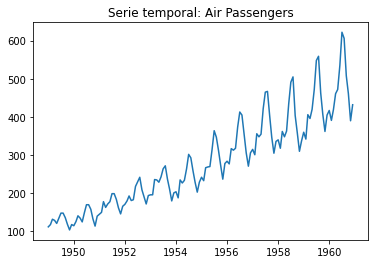

In [8]:
from matplotlib import pyplot as plt
plt.plot(data)
plt.title('Serie temporal: Air Passengers')

## 1.3. Estudio de la estacionariedad de la serie


Algunos de los modelos de análisis de series temporales asumen estacionariedad en las series. Por ello, vamos a ver dos métodos para comprobar si una serie es estacionaria.

Uno de ellos es un análisis más visual: calculamos la media y desviación estándar "móviles" (con una ventana deslizante). 

In [9]:
import pandas as pd

def test_stationarity_1(timeseries,window_size):
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=window_size).mean()
    rolstd = timeseries.rolling(window=window_size).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

El segundo método consiste en el test estadístico Dickey-Fuller:

In [10]:
import pandas as pd

from statsmodels.tsa.stattools import adfuller
def test_stationarity_2(timeseries):    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [11]:
def test_stationarity(timeseries,window_size):
  test_stationarity_1(timeseries,window_size)
  test_stationarity_2(timeseries)

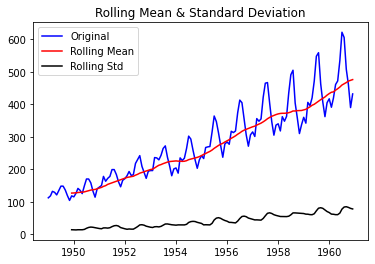

Results of Dickey-Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [12]:
test_stationarity(data,12)

**PREGUNTAS**

**1.   ¿Qué conclusiones puede extraer del análisis de estacionariedad de la serie original?**

 Que no es estacionaria, la media no se mantiene constante según evoluciona el tiempo. Lo podemos ver de manera visual con la salida de test_stationarity_1(), que muestra como la media va creciendo con el tiempo. La desviación también, aunque de un modo más débil(según el criterio visual la desviación la podemos considerar con estacionariedad debil.)
 
 Dada que la hipotesis nula es que no es estacionaria, obteniendo un p-value tan grande(un 0.991880 ), no podemos rechazarla para ninguno de los valores críticos(1,5 o 10%). Es decir, la serie no es estacionaria.
 



**2.   ¿Qué diferencias observas al variar el tamaño de la ventana para hacer las medias móviles? Prueba con un par de tamaños, incluye las gráficas obtenidas y explica las diferencias visuales que aprecias.**

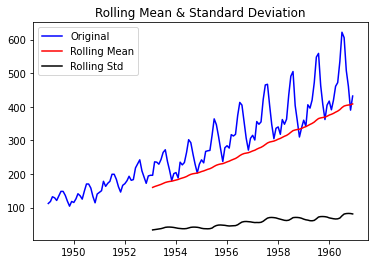

Results of Dickey-Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [13]:
test_stationarity(data,50)

Para un tamaño grande, de 50, las lineas obvian los primeros valores de la serie(ya que para  las primeras muestras no hay suficientes datos para la ventana). Al tender a promediar con más valores(tamaño de ventanan más grande)la media y desviación tienden a ser más constantes en el tiempo, es decir con menos varianza, aunque mantienen sus carácter creciente.

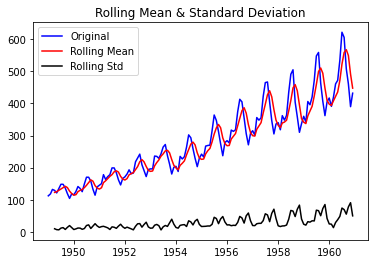

Results of Dickey-Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [14]:
test_stationarity(data,4)

Aumentando el tamaño de la ventana a un valor de 4, vemos como la media tiende a interpolar sobre la serie original, y como vemos, tanto la media como la desviación, tienen más picos, es decir, tienen una varianza mayor. Además vemos como ya no ignoran los primeros resultados de la serie original.

En ambos casos observamos como la condición de no estacionariedad se mantiene.

## 1.4. Transformar una serie temporal en estacionaria

Como hemos visto en la teoría, para analizar la serie y poder ajustarle un modelo tipo AR, MA o ARMA, esperamos que la serie a modelar sea estacionaria. 

Para conseguir una serie lo más estacionaria posible, podemos aplicar distintas transformaciones de la serie original. Vamos a ver algunos ejemplos:

a) *Transformaciones simples para reducir el efecto de la tendendia*:

En el caso de los datos del ejemplo, la tendencia es positiva, por lo que podemos aplicar alguna transformación que penalice los valores más altos y menos los más bajos. Es el caso del logaritmo, la raíz cuadrada, etc. 

**PREGUNTA**


**1.   Representa a continuación la serie aplicándole una transformación logarítmica. ¿Qué observas?**



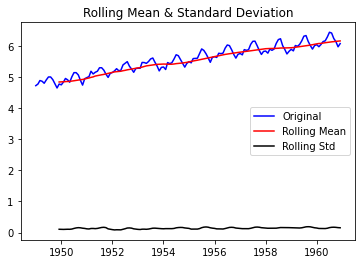

Results of Dickey-Fuller Test:
Test Statistic                  -1.717017
p-value                          0.422367
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [15]:
window_size = 12
data_log = np.log(data)
data_log = data_log.dropna()
test_stationarity(data_log,12)

Que la serie se suaviza y penalizando los valores más altos y no tanto los más bajos, aunque sigue sin ser estacionaria. Esto se puede ver visualmente o contrastándolo con un p-value grande, del 41%, mayor que los valors críticos. 

Como era de esperar la desviación se estabiliza muchísimo, y de modo visual, manteniéndose casi constante con la evolución del tiempo.

------------------------------------------------

En casos más complejos en los que la tendencia no se ve clara (sobre todo en presencia de ruido), se pueden aplicar otros métodos. Uno de ellos es el suavizado como las medias móviles (*moving average*). 

Por ejemplo, podemos aplicar un suavizado con una media con ventana deslizante que tenga en cuenta un año (12 meses). 
Ten en cuenta, que esto implicará que para calcular la media de las primeras muestras, no tengo suficientes datos para la ventana. Esto lo podemos ver en la salida de la media móvil (tendremos que eliminar los *NaN* que aparecen).


**PREGUNTAS**


**1.   Aplica dicha media móvil y represéntala junto a los datos. Puede utilizar los datos en escala logarítmica. ¿Esta media móvil representa claramente la tendencia de la serie?**


**2.   Elimina ahora de la serie original (transformada con el logaritmo si es como la has calculado previamente) la influencia de esta media móvil y representa el resultado. ¿Qué observas ahora?**






In [16]:
window_size=12
rollingmean =  data_log.rolling(window=window_size).mean()
data_log_rollingmean = data_log - rollingmean
data_log_rollingmean = data_log_rollingmean.dropna()


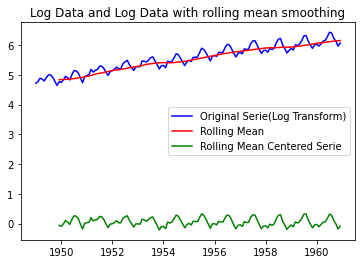

In [17]:
plt.plot(data_log, color='blue',label='Original Serie(Log Transform)')
plt.plot(rollingmean , color='red', label='Rolling Mean ')
plt.plot(data_log_rollingmean , color='green', label='Rolling Mean Centered Serie')
plt.legend(loc='best')
plt.title('Log Data and Log Data with rolling mean smoothing')
plt.show(block=False)

Sí, la media móvil representa la tendencia de la serie original.
Representado la resta de la serie original con la media móvil vemos  como ahora se ha eliminado el crecimiento(la tendencia) y ahora visualmente podemos considerarla estacionaria. Vamos a comprobarlo con el test:



**3.   Realiza el test de estacionariedad de la serie resultante y compáralo con el de la serie original. ¿Qué conclusiones puedes obtener tanto del test visual como del test estadístico?**


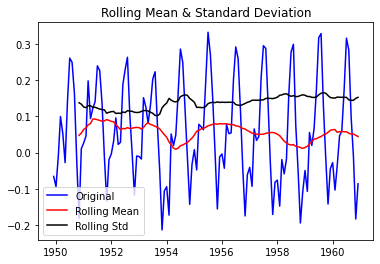

Results of Dickey-Fuller Test:
Test Statistic                  -3.162908
p-value                          0.022235
#Lags Used                      13.000000
Number of Observations Used    119.000000
Critical Value (1%)             -3.486535
Critical Value (5%)             -2.886151
Critical Value (10%)            -2.579896
dtype: float64


In [18]:
test_stationarity(data_log_rollingmean,12)

Confirmamos nuestro análisis visual, y vemos como hemos conseguido una serie estacionaria: el p-value es próximo a cero y es menor que el valor críticico del 1%, del 5% y del 10%, por lo que ahora podemos rechazar la hipótesis nula, y confirmar que la serie es estacionaria.

b) *Diferenciar (derivar)*:

Las técnicas anteriores son sencillas y pueden eliminar parte de la influencia de la tendencia de la serie, pero no suelen ser suficientes cuando se tiene por ejemplo estacionalidad. 

Diferenciar (o derivar) es uno de los métodos más comunes para eliminar la influencia de la tendencia y la estacionalidad en la serie original, mejorando las propiedades de estacionariedad de la serie. 

Podemos tomar la derivada de orden uno de la siguiente manera (partimos de la serie en el dominio logarítmico): 

Text(0.5, 1.0, ' Derivada Orden 1 de Log Data')

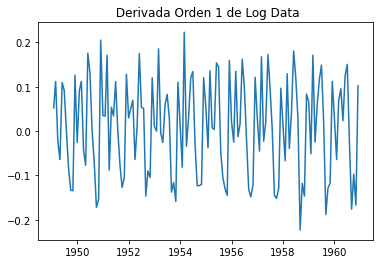

In [19]:
data_log = np.log(data)
data_log_diff = data_log - data_log.shift()
data_log_diff = data_log_diff.dropna()
plt.plot(data_log_diff)
plt.title(' Derivada Orden 1 de Log Data')


**PREGUNTAS**


**1.   ¿Qué observas en la serie resultante?**

Que ahora la media se mantiene constante, y por tanto la serie ahora es estacionaria. Además también se ha reducido considerablemente la estacionalidad, cosa que no ocurria cuando empleábamos el método de la media movil para eliminar la tendencia.

**2.   ¿Es esta serie estacionaria de acuerdo a los criterios anteriores? Incluye los resultados gráficos y del test estadístico e interprétalos.**

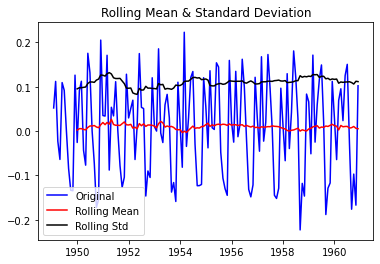

Results of Dickey-Fuller Test:
Test Statistic                  -2.717131
p-value                          0.071121
#Lags Used                      14.000000
Number of Observations Used    128.000000
Critical Value (1%)             -3.482501
Critical Value (5%)             -2.884398
Critical Value (10%)            -2.578960
dtype: float64


In [20]:
test_stationarity(data_log_diff,12)

Con el el p-value próximo a cero, vemos, confirmamos que la serie ahora es estacionaria, ya que la media y la desviación se mantienen constantes. De nuevo siguiendo el razomiento similar a los casos anteriores. Solo que con este método hemos difuminado considerablemente la estacionalidad de la serie original.


**3. Repite el proceso para una segunda derivada. ¿Qué observas ahora?**



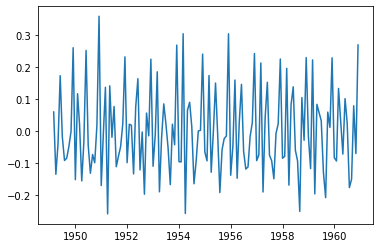

In [21]:
data_log = np.log(data)
data_log_diff_2 = data_log_diff - data_log_diff.shift()
data_log_diff_2 = data_log_diff_2.dropna()
plt.plot(data_log_diff_2)

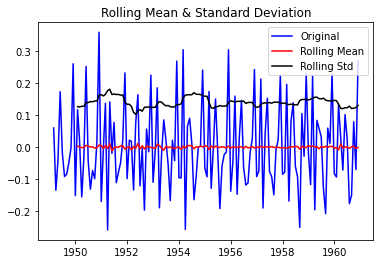

Results of Dickey-Fuller Test:
Test Statistic                -8.196629e+00
p-value                        7.419305e-13
#Lags Used                     1.300000e+01
Number of Observations Used    1.280000e+02
Critical Value (1%)           -3.482501e+00
Critical Value (5%)           -2.884398e+00
Critical Value (10%)          -2.578960e+00
dtype: float64


In [22]:
test_stationarity(data_log_diff_2,12)

Que la serie ahora también es estacionaria, pero con un p-valor mucho menor(prácticamente 0), con lo que podemos estar mucho más seguros en el proceso de transformar la serie para que sea estacionaria. Es decir, el método de la segunda derivada es mucho más eficaz y consigue mejores resultados. Además vemos como la estacinalidad también se difumina mucho más que con la derivada de orden 1. Así de este modo podemos considerar este método como uno más eficaz que el de la derivada de orden 1 para nuestro propósito.

c) *Descomposición de la serie*:

La mayoría de series pueden descomponerse en tendencia, estacionalidad y residuo, como hemos visto en clase. 

Utilizando la función *seasonal_decompose* del módulo de Python *statsmodels* podemos obtener estas tres componentes y por tanto, modelarlas por separado: 

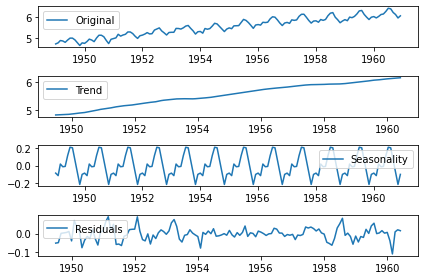

In [23]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(data_log)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(data_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

**PREGUNTAS**

**1.   ¿Es la señal residual estacionaria? Realiza el test y comenta los resultados.**



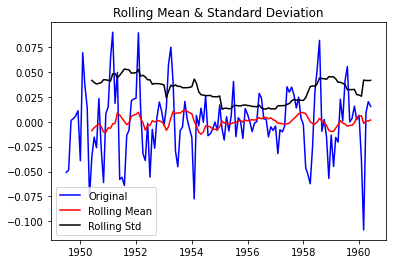

Results of Dickey-Fuller Test:
Test Statistic                -6.332387e+00
p-value                        2.885059e-08
#Lags Used                     9.000000e+00
Number of Observations Used    1.220000e+02
Critical Value (1%)           -3.485122e+00
Critical Value (5%)           -2.885538e+00
Critical Value (10%)          -2.579569e+00
dtype: float64


In [24]:
residual_clean = residual.dropna()
test_stationarity(residual_clean,12)

Siguiendo el mismo el mismo razomiento que en casos anteriores, bajo el test podemos decir que el ruido si es estacionario(para valores críticos del 5% y del 10%, pero no del 1%). Dado que son realizaciones independientes, y consideramos que se generan de una normal N(0,$\sigma^2 $), al tener media y desviación teóricas constentes, vemos como se cumple y por tanto el ruido es estacionario. 

## 1.5. Modelado ARIMA y predicción

Uno de los modelos clásicos para series temporales vistos en clase es el modelo ARIMA, que permite derivar *d* veces, y aplicar *p* coeficientes autorregresivos (AR) y *q* términos de error (shocks, provenientes de la parte MA) en la combinación lineal.  

Para determinar el valor de los parámetros *p* y *q*, podemos hacer uso de las funciones de autocorrelación (ACF) y autocorrelación parcial (PACF). 

Si calculamos dichas funciones para la serie derivada previamente, obtenemos lo siguiente:

Text(0.5, 1.0, 'Partial Autocorrelation Function')

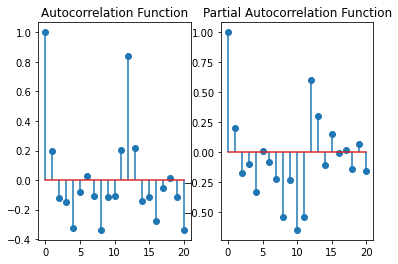

In [25]:
#ACF and PACF plots:
from statsmodels.tsa.stattools import acf, pacf
lag_acf = acf(data_log_diff, nlags=20, fft=False)
lag_pacf = pacf(data_log_diff, nlags=20, method='ols')

#Plot ACF: 
plt.subplot(121) 
plt.stem(lag_acf,use_line_collection=True)
plt.title('Autocorrelation Function')

#Plot PACF:
plt.subplot(122)
plt.stem(lag_pacf,use_line_collection=True)
plt.title('Partial Autocorrelation Function')

Podemos añadir además un intervalo de confianza a ambos lados del valor cero, de tal manera que el primer valor de retardo que cruce ese intervalo por arriba en la función de PACF será el valor de *p*, y de ACF, será *q*.

Para los niveles de confianza estándar, el valor del límite del intervalo de confianza al 95% es 1.96. Suponiendo desviación estándar unidad, el límite estaría en (-1.96/sqrt(N), 1.96/sqrt(N)), donde N es el número de puntos. 

Si incluimos estos límites en la figura anterior, podemos obtener una buena aproximación de los valores de *p* y *q* para el modelo ARIMA:

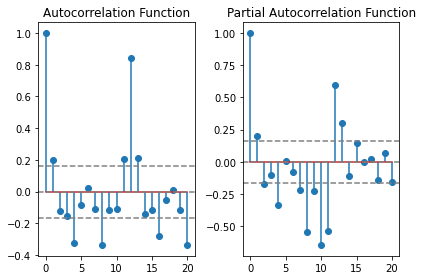

In [26]:
#Plot ACF: 
plt.subplot(121) 
plt.stem(lag_acf,use_line_collection=True)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(data_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(data_log_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

#Plot PACF:
plt.subplot(122)
plt.stem(lag_pacf,use_line_collection=True)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(data_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(data_log_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

**PREGUNTAS**


**1.   ¿Qué valores de *p* y *q* utilizarías para un primer modelo ARIMA de acuerdo a las representaciones anteriores?**

Vemos como en ambos casos, el valor de p y q son el punto numero 2 de las series acf y pacf(es decir en desplazamiento 1), ya que son los primeros valores de retardo que superar por arriba el intervalo de confianza(suponiedo que en 0 no hay retardo por definición)

In [27]:
limite_superior_acf =1.96/np.sqrt(len(data_log_diff))
limite_superior_pacf = 1.96/np.sqrt(len(data_log_diff))
print('limite_superior_acf',limite_superior_acf)
print('limite_superior_pacf',limite_superior_pacf)
primer_valor_cruzar_acf = lag_acf[1]
primer_valor_cruzar_pacf = lag_pacf[1]
print('primer_valor_cruzar_acf',primer_valor_cruzar_acf)
print('primer_valor_cruzar_pacf',primer_valor_cruzar_pacf)
                                    

limite_superior_acf 0.1639034339613898
limite_superior_pacf 0.1639034339613898
primer_valor_cruzar_acf 0.19975133672425988
primer_valor_cruzar_pacf 0.2008150828442731


Los valores escogidos de p y q son por tanto 1 y 1 respectivamente.  


----

Una vez elegidos los valores de *p* y *q*, podemos utilizar también la derivación interna de la clase ARIMA (*d*) o aplicarlo sobre la serie previamente derivada con valor de *d=0*. 

A continuación, importamos el modelo ARIMA de la siguiente manera. 

Este modelo tiene como argumentos los datos, y el orden: 

model = ARIMA(datos, order = (p,d,q))

In [29]:
from statsmodels.tsa.arima_model import ARIMA
# ERROR deprecated: from statsmodels.tsa.arima_model import ARIMA
#from statsmodels.tsa.arima.model import ARIMA

**PREGUNTAS**


**1.   A continuación, completa los valores de p, d y q y utiliza el siguiente código para ajustar un modelo tipo AR. Incluye el resultado en el informe de la práctica así como los valores elegidos. ¿Qué error de ajuste (RSS) se obtiene?**



*Ajustamos primero un modelo AR:* Escogiendo ajustar p=1 parámetros del AR, q=0 del MA y d=1 derivaciones del ARIMA.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Text(0.5, 1.0, 'RSS: 1.5476')

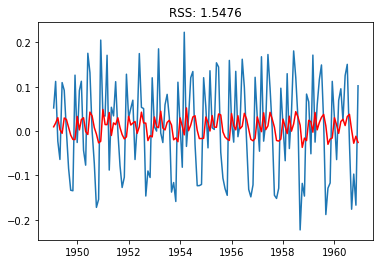

In [30]:
p_ar = 1
d_ar = 1
q_ar = 0


# AR
model = ARIMA(data_log, order=(p_ar, d_ar, q_ar))  
results_AR = model.fit(disp=-1)  
#results_AR = model.fit()  

plt.plot(data_log_diff)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum(((results_AR.fittedvalues-data_log_diff).dropna())**2)) 
# RSS: Residual sum of squares

Obtenemos un RSS de RSS: 1.5476

**2.    Repite el código con los valores de los parámetros correspondientes para ajustar un modelo MA. Incluye el resultado en el informe de la práctica así como los valores elegidos. ¿Qué error de ajuste (RSS) se obtiene?**

*Ajustamos primero un modelo AR:* Escogiendo ajustar p=0 parámetros del AR, q=1 del MA y d=1 derivaciones del ARIMA.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Text(0.5, 1.0, 'RSS: 1.5245')

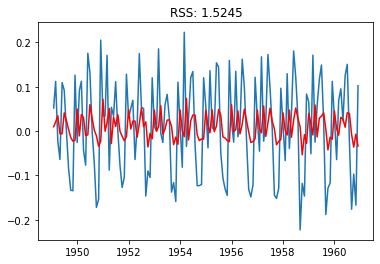

In [31]:
p_ma = 0
d_ma = 1
q_ma = 1


# MA
model = ARIMA(data_log, order=(p_ma, d_ma, q_ma))  
#results_AR = model.fit(disp=-1)  
results_MA = model.fit()  

plt.plot(data_log_diff)
plt.plot(results_MA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum(((results_MA.fittedvalues-data_log_diff).dropna())**2)) 
# RSS: Residual sum of squares

Obtenemos un RSS de 1.5245

**3.    Repite nuevamente el código para combinar los modelos anteriores (ARMA). Incluye el resultado en el informe de la práctica así como los valores elegidos. ¿Qué error de ajuste (RSS) se obtiene?**



*Ajustamos primero un modelo ARMA:* Escogiendo ajustar p=1 parámetros del AR, q=1 del MA y d=1 derivaciones del ARIMA.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Text(0.5, 1.0, 'RSS: 1.4597')

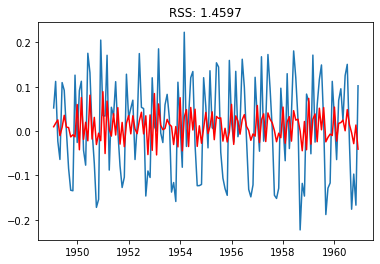

In [32]:
p_arma = 1
d_arma = 1
q_arma = 1


# AR
model = ARIMA(data_log, order=(p_arma, d_arma, q_arma))  
#results_AR = model.fit(disp=-1)  
results_ARMA = model.fit()  

plt.plot(data_log_diff)
plt.plot(results_ARMA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum(((results_ARMA.fittedvalues-data_log_diff).dropna())**2)) 
# RSS: Residual sum of squares

Obtenemos un RSS de 1.4597

**4.   De acuerdo a los valores de RSS, ¿cuál dirías que es el modelo que mejor se ajusta a los datos?**

El modelo ARMA con la derivada ajustado(el último de los 3), ya que con el es el valor más bajo que obtenemos para el RSS.






----------------------------------

Por último, para predecir valores en el espacio original, tenemos que deshacer las transformaciones realizadas hasta el momento. 

Primero, tomamos los valores ajustados por el modelo (predicciones) y los guardamos como serie temporal. 

Estos valores empiezan en el segundo mes, puesto que hemos tomado diferencias (derivada) de orden 1.

In [36]:
# Predicciones en el espacio original
predictions_ARIMA_diff = pd.Series(results_ARMA.fittedvalues, copy=True)
print(predictions_ARIMA_diff.head())


Month
1949-02-01    0.009800
1949-03-01    0.017618
1949-04-01    0.025229
1949-05-01   -0.010225
1949-06-01    0.008528
dtype: float64


Segundo, deshacemos la operación de diferencias (en escala logarítmica), con una suma acumulativa y añadiéndoles el valor "base" (primer elemento de la serie). 

In [37]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
print(predictions_ARIMA_diff_cumsum.head())

Month
1949-02-01    0.009800
1949-03-01    0.027418
1949-04-01    0.052648
1949-05-01    0.042422
1949-06-01    0.050950
dtype: float64


In [38]:
predictions_ARIMA_log = pd.Series(data_log[0], index=data_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
print(predictions_ARIMA_log.head())

Month
1949-01-01    4.718499
1949-02-01    4.728299
1949-03-01    4.745917
1949-04-01    4.771146
1949-05-01    4.760921
dtype: float64


Finalmente, aplicamos la función exponencial (inversa del logaritmo).

Podemos calcular el error cuadrático medio en el espacio original. 

Text(0.5, 1.0, 'RMSE: 52.4891')

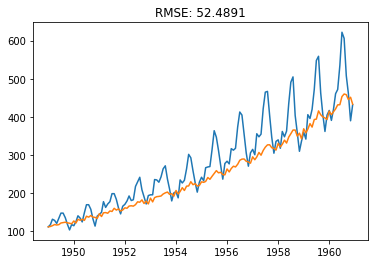

In [39]:
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(data)
plt.plot(predictions_ARIMA)
plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA-data)**2)/len(data)))

# 2. Aplicación a otros datos: Vacunación COVID República Checa


Vamos a cargar ahora los datos sobre la vacunación COVID de República Checa (*COVIDVaccinationCZ.csv*):

In [40]:
from google.colab import files
uploaded = files.upload()

Saving COVIDVaccinationCZ.csv to COVIDVaccinationCZ.csv


Esta base de datos, contiene los datos de vacunación de República Checa desde el 27 de diciembre de 2020 hasta el 7 de febrero de 2022. 

In [41]:
from pandas import read_csv
from pandas import datetime
from matplotlib import pyplot
 
def parser(x):
	return datetime.strptime(x, '%Y-%m-%d')
 
data = read_csv('COVIDVaccinationCZ.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
print(data.head())

Fecha
2020-12-27    1283
2020-12-28    2305
2020-12-29    3464
2020-12-30    3521
2020-12-31    1307
Name: NumVacunas, dtype: int64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  


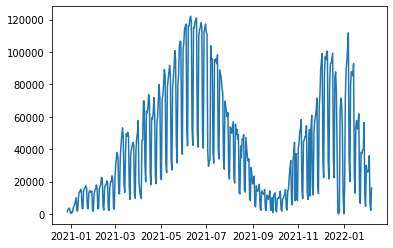

In [42]:
from matplotlib import pyplot as plt
plt.plot(data)

**PREGUNTAS**

Utilizando las herramientas del apartado 1, realiza el análisis de esta serie (puedes utilizar un intervalo de ella o la serie completa). 

En concreto:

**1.   Analiza la estacionariedad de esta serie.**

Cogemos tamaños de ventana distintos y comprobamos los resultados. Los tamaños de ventana son 1,7,15 y 30 días.

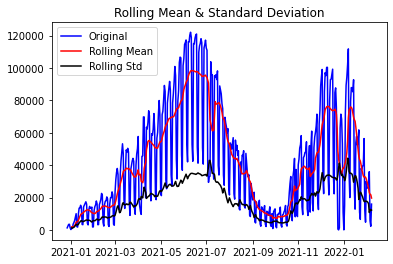

Results of Dickey-Fuller Test:
Test Statistic                  -2.052545
p-value                          0.264019
#Lags Used                      14.000000
Number of Observations Used    393.000000
Critical Value (1%)             -3.447099
Critical Value (5%)             -2.868923
Critical Value (10%)            -2.570703
dtype: float64


In [49]:
test_stationarity(data,7)

Observamos para todos ellos, que la serie no es estacionaria, ya que la media y la desviación no es constante. Obtenemos un p-valor de 0.26

 
**2. ¿Qué transformaciones puedes realizar para hacerla más estacionaria.Prueba algunas y justifica si consigues una serie más estacionaria.**

La primera transformación que vamos a hacer es aplicar el **logaritmo** para penalizar los valores más altos, y los más bajos mantenerlos estables:

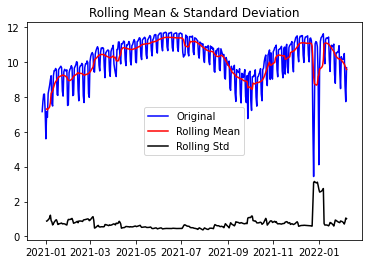

Results of Dickey-Fuller Test:
Test Statistic                  -3.447442
p-value                          0.009444
#Lags Used                       7.000000
Number of Observations Used    400.000000
Critical Value (1%)             -3.446804
Critical Value (5%)             -2.868793
Critical Value (10%)            -2.570634
dtype: float64


In [62]:
window_size = 7
data_log = np.log(data)
data_log = data_log.dropna()
test_stationarity(data_log,window_size)

Observamos como conseguimos estacionariedad con un p-valor de 0.009 y un tamaño de ventana de 7 días, pero consideramos que podemos mejorar esta transformación con otro método.

Por ello vamos a aplicarle ahora una transformación de la **raiz cuadrada**(ya que solo tenemos enteros sobre número de vacunaciones):


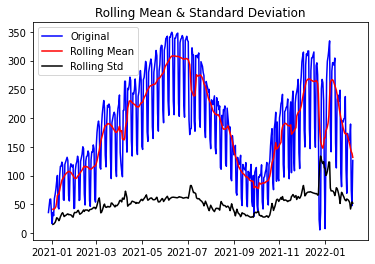

Results of Dickey-Fuller Test:
Test Statistic                  -2.043689
p-value                          0.267751
#Lags Used                      15.000000
Number of Observations Used    392.000000
Critical Value (1%)             -3.447142
Critical Value (5%)             -2.868941
Critical Value (10%)            -2.570713
dtype: float64


In [61]:
window_size = 7
data_sqrt = np.sqrt(data)
data_sqrt = data_sqrt.dropna()
test_stationarity(data_sqrt,window_size)

No conseguimos tranformar la serie en estacionaria con este método, así que probamos más metodos alternativos.

Sabemos que la transformación  **Moving Average** nos da la tendencia de la serie , así que vamos a eliminársela. Para ello a los datos logarímicos, vamos a restarle la media movil:

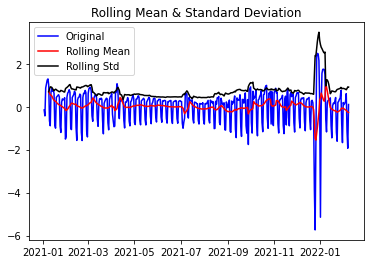

Results of Dickey-Fuller Test:
Test Statistic                -6.266222e+00
p-value                        4.107849e-08
#Lags Used                     1.400000e+01
Number of Observations Used    3.870000e+02
Critical Value (1%)           -3.447361e+00
Critical Value (5%)           -2.869037e+00
Critical Value (10%)          -2.570764e+00
dtype: float64


In [63]:
window_size=7
rollingmean =  data_log.rolling(window=window_size).mean()
data_log_rollingmean = data_log - rollingmean
data_log_rollingmean = data_log_rollingmean.dropna()
test_stationarity(data_log_rollingmean,window_size)

Observamos como **hemos conseguido de manera mucho más efectiva eliminar la estacionaridad**, con el p-valor a prácticamente cero.

Vamos a probar por último la técnica de la **derivada para el dominio logaritmico** por dar buenos resultados:

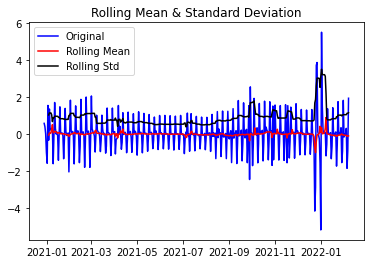

Results of Dickey-Fuller Test:
Test Statistic                -1.094922e+01
p-value                        8.885075e-20
#Lags Used                     6.000000e+00
Number of Observations Used    4.000000e+02
Critical Value (1%)           -3.446804e+00
Critical Value (5%)           -2.868793e+00
Critical Value (10%)          -2.570634e+00
dtype: float64


In [65]:
data_log = np.log(data)
data_log_diff = data_log - data_log.shift()
data_log_diff = data_log_diff.dropna()
test_stationarity(data_log_diff,7)

Vemos como de nuevo **hemos conseguido eliminar la estacionariedad de la serie, **de un modo más efectivo que el dominio logarítmico con la eliminación del efecto del moving average, pues que el p-valor el el doble de proximo a cero.

**3.   Ajusta un modelo ARIMA, y calcula el error de predicción.**

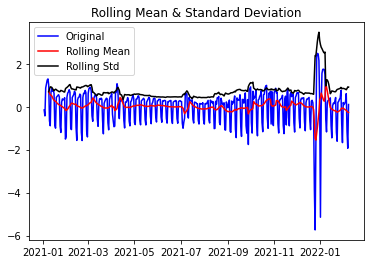

Results of Dickey-Fuller Test:
Test Statistic                -6.266222e+00
p-value                        4.107849e-08
#Lags Used                     1.400000e+01
Number of Observations Used    3.870000e+02
Critical Value (1%)           -3.447361e+00
Critical Value (5%)           -2.869037e+00
Critical Value (10%)          -2.570764e+00
dtype: float64


In [140]:
window_size=7
data_log = np.log(data)
rollingmean =  data_log.rolling(window=window_size).mean()
data_log_rollingmean = data_log - rollingmean
data_log_rollingmean = data_log_rollingmean.dropna()
test_stationarity(data_log_rollingmean,window_size)

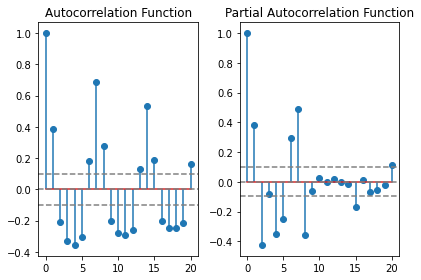

In [141]:
from statsmodels.tsa.stattools import acf, pacf
lag_acf = acf(data_log_rollingmean, nlags=20, fft=False)
lag_pacf = pacf(data_log_rollingmean, nlags=20, method='ols')


#Plot ACF: 
plt.subplot(121) 
plt.stem(lag_acf,use_line_collection=True)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(data_log_rollingmean)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(data_log_rollingmean)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

#Plot PACF:
plt.subplot(122)
plt.stem(lag_pacf,use_line_collection=True)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(data_log_rollingmean)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(data_log_rollingmean)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Text(0.5, 1.0, 'RSS: 208.3982')

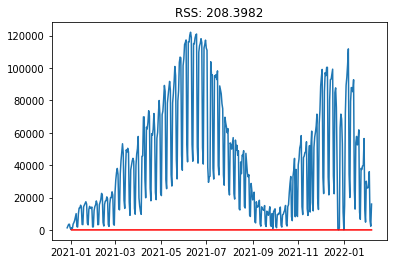

In [142]:
p_arma = 1
d_arma = 0
q_arma = 1


# ARMA
model = ARIMA(data_log_rollingmean, order=(p_arma, d_arma, q_arma))  
results_ARMA = model.fit(disp=-1)  

plt.plot(data)
plt.plot(results_ARMA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum(((results_ARMA.fittedvalues-data_log_rollingmean).dropna())**2)) 
# RSS: Residual sum of squares

In [144]:
# Predicciones en el espacio original
predictions_ARIMA = pd.Series(results_ARMA.fittedvalues, copy=True)
print(predictions_ARIMA.head())


Fecha
2021-01-02    0.017068
2021-01-03   -0.052755
2021-01-04   -0.173970
2021-01-05    0.615005
2021-01-06    0.225498
dtype: float64


In [145]:
predictions_ARIMA_log = predictions_ARIMA + rollingmean

Text(0.5, 1.0, 'RMSE: 19965.9866')

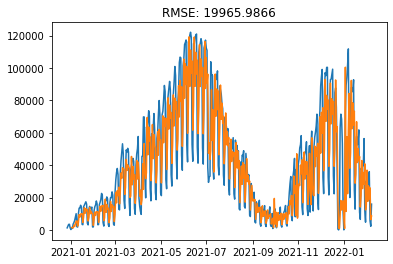

In [149]:
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(data)
plt.plot(predictions_ARIMA)
plt.title('RMSE: %.4f'% np.sqrt(sum( ((predictions_ARIMA-data).dropna())**2)/len(data)))

Vemos como los errores obtenidos son muy altos debido a la variabilidad de la serie original junto con la predicción,aunque sin embargo en forma y ajuste general vemos como la predicción se parece a la serie original